In [4]:
import os
import sys
sys.path.append('/scratch/ne2213/projects/tmp_packages')
sys.path.append('/scratch/ne2213/projects/tmp_packages/')
sys.path.append('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsd')
import struct
import time
import numpy as np
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
fpX = np.float32
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
import torch as T
import torch.nn as L
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim
import torch
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi
from src.load_nsd import  image_feature_fn, data_split
import h5py
import glob
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from PIL import Image
from src.numpy_utility import mosaic_vis, iterate_minibatches
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi
from src.load_nsd import image_feature_fn, data_split
import os.path as op
import nibabel as nb
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.image as mpimg
import urllib.request
import zipfile
from pycocotools.coco import COCO
from IPython import embed

In [5]:
class NSDAccess(object):

    def __init__(self, nsd_folder, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.nsd_folder = nsd_folder
        self.nsddata_folder = op.join(self.nsd_folder, 'nsddata')
        self.ppdata_folder = op.join(self.nsd_folder, 'nsddata', 'ppdata')
        self.nsddata_betas_folder = op.join(
            self.nsd_folder, 'nsddata_betas', 'ppdata')

        self.behavior_file = op.join(
            self.ppdata_folder, '{subject}', 'behav', 'responses.tsv')
        self.stimuli_file = op.join(
            self.nsd_folder, 'nsddata_stimuli', 'stimuli', 'nsd', 'nsd_stimuli.hdf5')
        self.stimuli_description_file = op.join(
            self.nsd_folder, 'nsddata', 'experiments', 'nsd', 'nsd_stim_info_merged.csv')

        self.coco_annotation_file = op.join(
            self.nsd_folder, 'nsddata_stimuli', 'stimuli', 'nsd', 'annotations', '{}_{}.json')
        
        
        
    def download_coco_annotation_file(self, url='http://images.cocodataset.org/annotations/annotations_trainval2017.zip'):

        print('downloading annotations from {}'.format(url))
        filehandle, _ = urllib.request.urlretrieve(url)
        zip_file_object = zipfile.ZipFile(filehandle, 'r')
        zip_file_object.extractall(path=op.split(
            op.split(self.coco_annotation_file)[0])[0])
        
    def read_images(self, image_index, show=False):

        if not hasattr(self, 'stim_descriptions'):
            self.stim_descriptions = pd.read_csv(
                self.stimuli_description_file, index_col=0)

        sf = h5py.File(self.stimuli_file, 'r')
        sdataset = sf.get('imgBrick')
        if show:
            f, ss = plt.subplots(1, len(image_index),
                                 figsize=(6*len(image_index), 6))
            if len(image_index) == 1:
                ss = [ss]
            for s, d in zip(ss, sdataset[image_index]):
                s.axis('off')
                s.imshow(d)
        return sdataset[image_index]     
        
        
        
    def read_image_coco_info(self, image_index, info_type='captions', show_annot=False, show_img=False):

        if not hasattr(self, 'stim_descriptions'):
            self.stim_descriptions = pd.read_csv(
                self.stimuli_description_file, index_col=0)
        if len(image_index) == 1:
            subj_info = self.stim_descriptions.iloc[image_index[0]]

            # checking whether annotation file for this trial exists.
            # This may not be the right place to call the download, and
            # re-opening the annotations for all images separately may be slowing things down
            # however images used in the experiment seem to have come from different sets.
            annot_file = self.coco_annotation_file.format(
                info_type, subj_info['cocoSplit'])
            print('getting annotations from ' + annot_file)
            if not os.path.isfile(annot_file):
                print('annotations file not found')
                self.download_coco_annotation_file()

            coco = COCO(annot_file)
            coco_annot_IDs = coco.getAnnIds([subj_info['cocoId']])
            coco_annot = coco.loadAnns(coco_annot_IDs)

            if show_img:
                self.read_images(image_index, show=True)

            if show_annot:
                # still need to convert the annotations (especially person_keypoints and instances) to the right reference frame,
                # because the images were cropped. See image information per image to do this.
                coco.showAnns(coco_annot)

        elif len(image_index) > 1:

            # we output a list of annots
            coco_annot = []

            # load train_2017
            annot_file = self.coco_annotation_file.format(
                info_type, 'train2017')
            coco_train = COCO(annot_file)

            # also load the val 2017
            annot_file = self.coco_annotation_file.format(
                info_type, 'val2017')
            coco_val = COCO(annot_file)

            for image in image_index:
                subj_info = self.stim_descriptions.iloc[image]
                if subj_info['cocoSplit'] == 'train2017':
                    coco_annot_IDs = coco_train.getAnnIds(
                        [subj_info['cocoId']])
                    coco_ann = coco_train.loadAnns(coco_annot_IDs)
                    coco_annot.append(coco_ann)

                elif subj_info['cocoSplit'] == 'val2017':
                    coco_annot_IDs = coco_val.getAnnIds(
                        [subj_info['cocoId']])
                    coco_ann = coco_val.loadAnns(coco_annot_IDs)
                    coco_annot.append(coco_ann)

        return coco_annot

    
    
    def read_image_coco_category(self, image_index):

        if not hasattr(self, 'stim_descriptions'):
            self.stim_descriptions = pd.read_csv(
                self.stimuli_description_file, index_col=0)

        if len(image_index) == 1:
            subj_info = self.stim_descriptions.iloc[image_index[0]]
            coco_id = subj_info['cocoId']

            # checking whether annotation file for this trial exists.
            # This may not be the right place to call the download, and
            # re-opening the annotations for all images separately may be slowing things down
            # however images used in the experiment seem to have come from different sets.
            annot_file = self.coco_annotation_file.format(
                'instances', subj_info['cocoSplit'])
            print('getting annotations from ' + annot_file)
            if not os.path.isfile(annot_file):
                print('annotations file not found')
                self.download_coco_annotation_file()

            coco = COCO(annot_file)

            cat_ids = coco.getCatIds()
            #categories = json_normalize(coco.loadCats(cat_ids))
            categories = pd.json_normalize(coco.loadCats(cat_ids))
            
            coco_cats = []
            for cat_id in cat_ids:
                this_img_list = coco.getImgIds(catIds=[cat_id])
                if coco_id in this_img_list:
                    this_cat = np.asarray(categories[categories['id']==cat_id]['name'])[0]
                    coco_cats.append(this_cat)

        elif len(image_index) > 1:

            # we output a list of annots
            coco_cats = []

            # load train_2017
            annot_file = self.coco_annotation_file.format(
                'instances', 'train2017')
            coco_train = COCO(annot_file)
            cat_ids_train = coco_train.getCatIds()
            #categories_train = json_normalize(coco_train.loadCats(cat_ids_train))
            categories_train = pd.json_normalize(coco_train.loadCats(cat_ids_train))

            # also load the val 2017
            annot_file = self.coco_annotation_file.format(
                'instances', 'val2017')
            coco_val = COCO(annot_file)
            cat_ids_val = coco_val.getCatIds()
            #categories_val = json_normalize(coco_val.loadCats(cat_ids_val))
            categories_val = pd.json_normalize(coco_val.loadCats(cat_ids_val))

            for image in tqdm(image_index, bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}'):
                subj_info = self.stim_descriptions.iloc[image]
                coco_id = subj_info['cocoId']
                image_cat = []
                if subj_info['cocoSplit'] == 'train2017':
                    for cat_id in cat_ids_train:
                        this_img_list = coco_train.getImgIds(catIds=[cat_id])
                        if coco_id in this_img_list:
                            this_cat = np.asarray(categories_train[categories_train['id']==cat_id]['name'])[0]
                            image_cat.append(this_cat)
                
                elif subj_info['cocoSplit'] == 'val2017':
                    for cat_id in cat_ids_val:
                        this_img_list = coco_val.getImgIds(catIds=[cat_id])
                        if coco_id in this_img_list:
                            this_cat = np.asarray(categories_val[categories_val['id']==cat_id]['name'])[0]
                            image_cat.append(this_cat)
                coco_cats.append(image_cat)
        return coco_cats

In [6]:
nsd = NSDAccess('/scratch/cl6707/Projects/neuro_interp/data/NSD/')

### Checking for a single image:

getting annotations from /scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata_stimuli/stimuli/nsd/annotations/captions_train2017.json
loading annotations into memory...
Done (t=0.93s)
creating index...
index created!
People shopping in an open market for vegetables.
An open market full of people and piles of vegetables.
People are shopping at an open air produce market.
Large piles of carrots and potatoes at a crowded outdoor market.
People shop for vegetables like carrots and potatoes at an open air market.


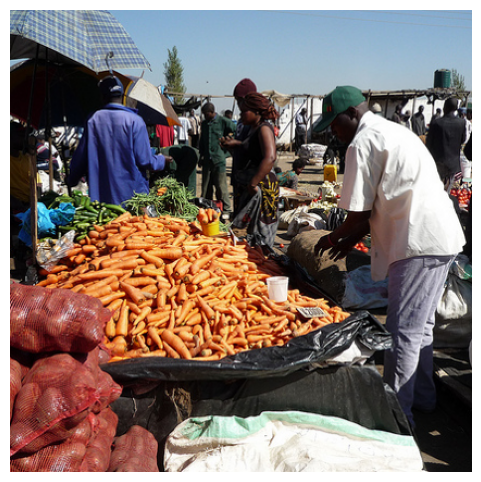

In [7]:
single_image_coco_info = nsd.read_image_coco_info([2950], info_type='captions', show_annot=True, show_img=True)

In [9]:
single_image_coco_info

[{'image_id': 262145,
  'id': 694,
  'caption': 'People shopping in an open market for vegetables.'},
 {'image_id': 262145,
  'id': 1054,
  'caption': 'An open market full of people and piles of vegetables.'},
 {'image_id': 262145,
  'id': 1456,
  'caption': 'People are shopping at an open air produce market.'},
 {'image_id': 262145,
  'id': 5248,
  'caption': 'Large piles of carrots and potatoes at a crowded outdoor market.'},
 {'image_id': 262145,
  'id': 5254,
  'caption': 'People shop for vegetables like carrots and potatoes at an open air market.'}]

In [ ]:
single_image_coco_category = nsd.read_image_coco_category([262239])
print(single_image_coco_category)

IndexError: single positional indexer is out-of-bounds

### Creating the annotations for all the data:

In [ ]:
all_image_indices = list(range(73000))

# Create empty lists to store the results
annotations_list = []
categories_list = []

# Iterate over all the image indices
for image_index in all_image_indices:
    # Call read_image_coco_info for annotations
    annotations = nsd.read_image_coco_info([image_index], info_type='captions')
    annotations_list.append(annotations)

    # Call read_image_coco_category for categories
    categories = nsd.read_image_coco_category([image_index])
    categories_list.append(categories)

getting annotations from /scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata_stimuli/stimuli/nsd/annotations/captions_val2017.json
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
getting annotations from /scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata_stimuli/stimuli/nsd/annotations/instances_val2017.json
loading annotations into memory...
Done (t=0.65s)
creating index...
index created!
getting annotations from /scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata_stimuli/stimuli/nsd/annotations/captions_val2017.json
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
getting annotations from /scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata_stimuli/stimuli/nsd/annotations/instances_val2017.json
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
getting annotations from /scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata_stimuli/stimuli/nsd/annotations/captions_val2017.j

In [ ]:
annotations_array = np.array(annotations_list)
output_file = '/scratch/ne2213/projects/IVP/annotations.npy'
np.save(output_file, annotations_array)

In [ ]:
categories_array = np.array(categories_list, dtype=object)
output_file = '/scratch/ne2213/projects/IVP/annotations.npy'
np.save(output_file, categories_array)